In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import pyccl.nl_pt as pt
import pyccl.ccllib as lib
from astropy import units as u
from astropy.coordinates import Angle
%pylab inline 
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


/global/common/software/lsst/common/miniconda/prod/envs/desc/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Preliminaries
Setting up a cosmology and defining the redshift distribution

In [2]:
cosmo = ccl.Cosmology(
    Omega_c=0.22, Omega_b=0.0448, 
    h=0.71, sigma8 = 0.801, n_s= 0.963,w0=-1.00,wa=0.0, Omega_k=0.0)

In [3]:
nzs=np.loadtxt("/global/u1/d/dlan/SkySim5000_IA_infusion/StageIV_zcen_nz_bin1-5.dat", unpack = True)

In [4]:
z=nzs[0]
nzs_s=nzs[1:]

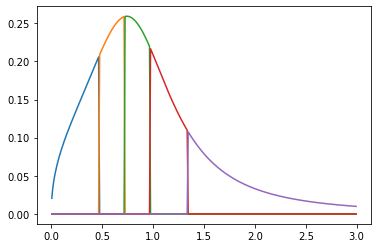

In [5]:
for i in range(len(nzs_s)):
    plot(z,nzs_s[i])

# IA normalization
these factors absorb the typical normalization factors used in the literature for intrinsic alignment amplitude and redshift evolution.

In [6]:
# Biases for IAs. Will be converted to the input c_IA values below.
a_1 = 1.
a_2 = 0.5
a_d = 0.5

In [7]:
c_1,c_d,c_2 = pt.translate_IA_norm(cosmo, z, a1=a_1, a1delta=a_d, a2=a_2,
                                   Om_m2_for_c2 = False)

# Tracers
Let's create the 3 PTTracers

In [8]:
# Intrinsic alignments
ptt_i = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1), c2=(z,c_2), cdelta=(z,c_d))
ptt_i_nla = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1)) # to compare using the standard WLTracer

# Matter
ptt_m = pt.PTMatterTracer()


In [9]:
ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-5, log10k_max=3, nk_per_decade=20)

# PT power spectra

In [10]:
# IAs x IAs
pk_ii, pk_ii_bb = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_i, ptc=ptc, return_ia_ee_and_bb=True)
pk_ii_nla = pt.get_pt_pk2d(cosmo, ptt_i_nla, tracer2=ptt_i_nla, ptc=ptc,)

# IAs x matter
pk_im = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_m, ptc=ptc)

# Matter x matter
pk_mm = pt.get_pt_pk2d(cosmo, ptt_m, tracer2=ptt_m, ptc=ptc)

In [11]:
ks = np.logspace(-4,2,512)
ps = {}
ps['ii'] = pk_ii.eval(ks, 1., cosmo)
ps['im'] = pk_im.eval(ks, 1., cosmo)
ps['mm'] = pk_mm.eval(ks, 1., cosmo)

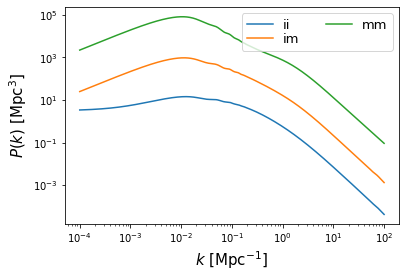

In [12]:
plt.figure()
for pn, p in ps.items():
    plt.plot(ks, abs(p), label=pn)
plt.loglog()
plt.legend(loc='upper right', ncol=2,
           fontsize=13, labelspacing=0.1)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^{3}]$', fontsize=15)
plt.show()

# Angular power spectra

In [13]:
# Lensing
tracers_len = []

for i in range(len(nzs_s)):
    t_l = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]))
    tracers_len.append(t_l)


In [14]:
# Intrinsic alignments
tracers_IA = []
for i in range(len(nzs_s)):
    t_i = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=False)
    tracers_IA.append(t_i)

In [15]:
# Intrinsic alignments
tracers_IA_nla = []
for i in range(len(nzs_s)):
    t_i_nla = ccl.WeakLensingTracer(cosmo, dndz=(z, nzs_s[i]), has_shear=False, ia_bias=(z, np.ones_like(z)), use_A_ia=True)
    tracers_IA_nla.append(t_i_nla)

In [16]:
# ell = np.unique(np.geomspace(2,1000,100).astype(int)).astype(float)
# cls={}
# cls['GG'] = np.stack([
#     ccl.angular_cl(cosmo, t, t, ell,p_of_k_a=pk_mm) for t in  tracers_len   
# ])


# cls['II'] =np.stack([
#     ccl.angular_cl(cosmo, t, t, ell,p_of_k_a=pk_ii) for t in tracers_IA    
# ])

# cls['II,NLA'] =np.stack([
#     ccl.angular_cl(cosmo, t, t, ell) for t in tracers_IA_nla    
# ])

In [17]:
ell = np.unique(np.geomspace(30,30000,1000).astype(int)).astype(float)
cls={}


cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_len[i], tracers_len[j], ell,p_of_k_a=pk_mm))
cls['GG'] = np.stack(cross)

cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_IA[i], tracers_IA[j], ell,p_of_k_a=pk_ii))
cls['II'] = np.stack(cross)

cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_IA_nla[i], tracers_IA_nla[j], ell))
cls['II,NLA'] = np.stack(cross)


cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_len[i],tracers_IA[j], ell, p_of_k_a=pk_im))
cls['GI'] =np.stack(cross)


cross=[]
for i in range(5):
    for j in range(i+1):
        cross.append(ccl.angular_cl(cosmo, tracers_len[i],tracers_IA_nla[j], ell))
cls['GI,NLA'] =np.stack(cross)

In [18]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
        plt.xlabel(r'$\theta$', fontsize=15)
        plt.ylabel(r'$\xi_+(\theta)$', fontsize=15)
    return axs[:N]

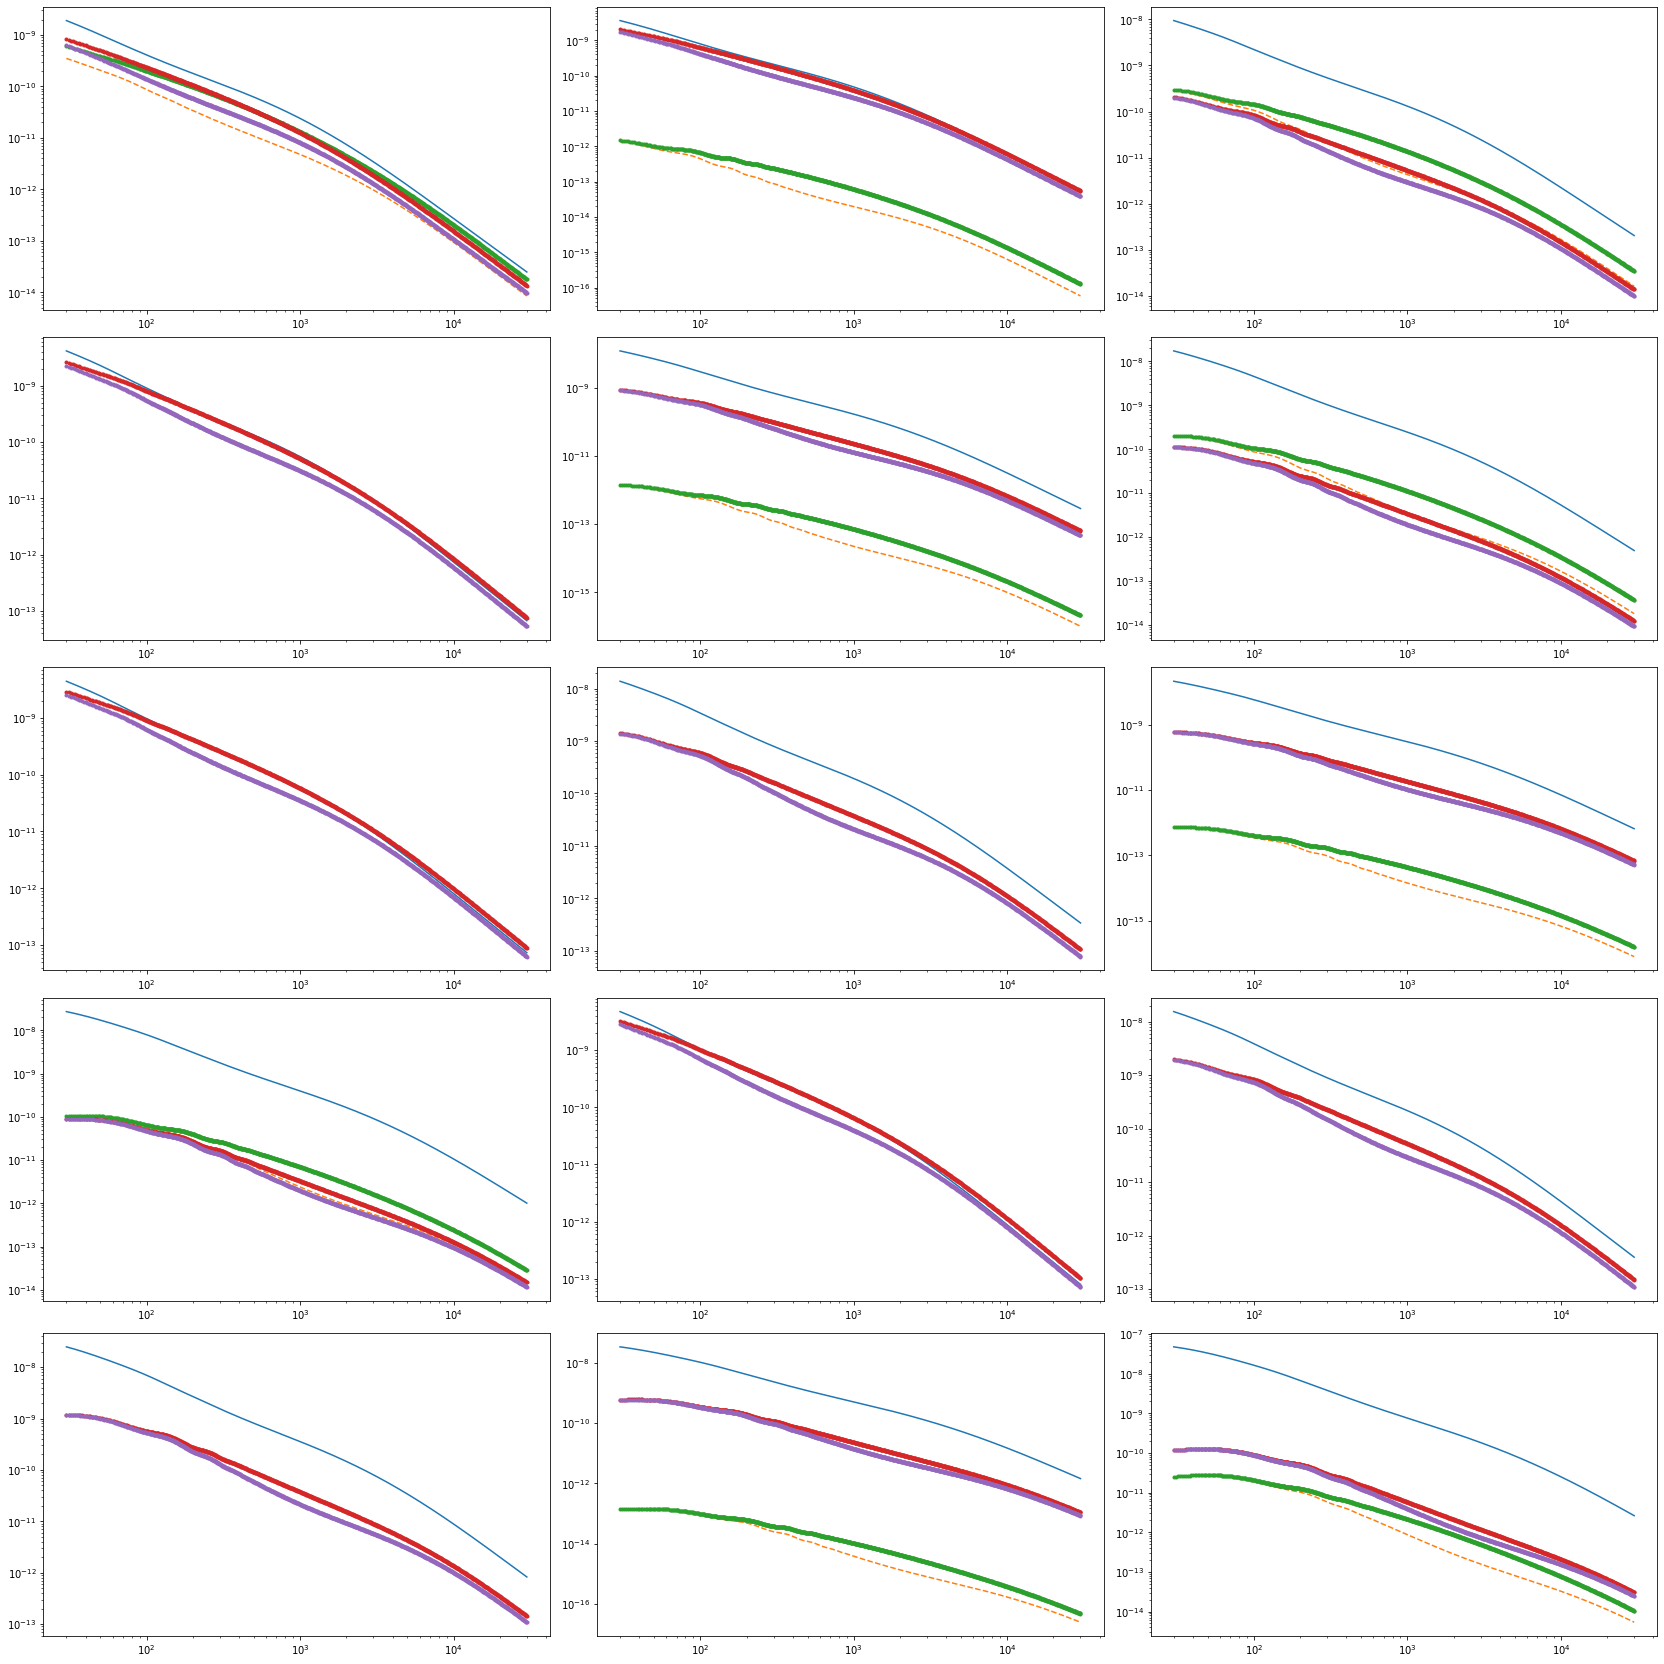

In [19]:
k=ell
figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 3
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(cls['GG']))
for ax, pi in zip(axs, cls['GG']):
    ax.loglog(ell, pi,label='No IA')
for ax, px in zip(axs, cls['II,NLA']):
    ax.loglog(ell, px,'--',label='II,NLA')
for ax, pj in zip(axs, cls['II']):
    ax.loglog(ell, pj,'.',label='II')
for ax, pjk in zip(axs, cls['GI']):
    ax.loglog(ell,-pjk,'.',label='-GI')
for ax, pjj in zip(axs, cls['GI,NLA']):
    ax.loglog(ell, -pjj,'.',label='-GI,NLA')

#     plt.xlabel(r'$\ell$', fontsize=15)
#     plt.ylabel(r'$\C_{\ell}(\ell)$', fontsize=15)
# legend(loc='upper right')

# Shear correlation function

In [20]:
theta =np.unique(np.geomspace(0.1,3000,1000).astype(int)).astype(float)

In [21]:
len(theta)

430

In [22]:
theta_arc=Angle(theta, u.arcmin)

In [23]:
shear_GG_plus=[]
for i in range(15): 
    shear_GG_plus.append(ccl.correlation(cosmo, ell, cls['GG'][i] ,theta_arc.deg , corr_type='L+', method='fftlog'))
shear_GG_plus=np.stack(shear_GG_plus)

/global/common/software/lsst/common/miniconda/prod/envs/desc/lib/python3.8/site-packages/pyccl/correlations.py:83: CCLWarning: corr_type is deprecated. Use type = GG+
  warnings.warn("corr_type is deprecated. Use type = {}".format(type),


In [24]:
shear_GG_minus=[]
for i in range(15): 
    shear_GG_minus.append(ccl.correlation(cosmo, ell, cls['GG'][i] ,theta_arc.deg, corr_type='L-', method='fftlog'))
shear_GG_minus=np.stack(shear_GG_minus)

/global/common/software/lsst/common/miniconda/prod/envs/desc/lib/python3.8/site-packages/pyccl/correlations.py:83: CCLWarning: corr_type is deprecated. Use type = GG-
  warnings.warn("corr_type is deprecated. Use type = {}".format(type),


In [25]:
shear_II_NLA_plus=[]
for i in range(15): 
    shear_II_NLA_plus.append(ccl.correlation(cosmo, ell,cls['II,NLA'][i] ,theta_arc.deg , corr_type='L+', method='fftlog'))
shear_II_NLA_plus=np.stack(shear_II_NLA_plus)

In [26]:
shear_II_NLA_minus=[]
for i in range(15): 
    shear_II_NLA_minus.append(ccl.correlation(cosmo, ell,cls['II,NLA'][i] ,theta_arc.deg , corr_type='L-', method='fftlog'))
shear_II_NLA_minus=np.stack(shear_II_NLA_minus)

In [27]:
shear_II_plus=[]
for i in range(15): 
    shear_II_plus.append(ccl.correlation(cosmo, ell,cls['II'][i] ,theta_arc.deg , corr_type='L+', method='fftlog'))
shear_II_plus=np.stack(shear_II_plus)

In [28]:
shear_II_minus=[]
for i in range(15): 
    shear_II_minus.append(ccl.correlation(cosmo, ell,cls['II'][i] ,theta_arc.deg , corr_type='L-', method='fftlog'))
shear_II_minus=np.stack(shear_II_minus)

In [29]:
shear_GI_plus=[]
for i in range(15): 
    shear_GI_plus.append(ccl.correlation(cosmo, ell,cls['GI'][i] ,theta_arc.deg , corr_type='L+', method='fftlog'))
shear_GI_plus=np.stack(shear_GI_plus)

In [30]:
shear_GI_minus=[]
for i in range(15): 
    shear_GI_minus.append(ccl.correlation(cosmo, ell,cls['GI'][i] ,theta_arc.deg , corr_type='L-', method='fftlog'))
shear_GI_minus=np.stack(shear_GI_minus)

In [31]:
shear_GI_NLA_plus=[]
for i in range(15): 
    shear_GI_NLA_plus.append(ccl.correlation(cosmo, ell,cls['GI,NLA'][i] ,theta_arc.deg , corr_type='L+', method='fftlog'))
shear_GI_NLA_plus=np.stack(shear_GI_NLA_plus)

In [32]:
shear_GI_NLA_minus=[]
for i in range(15): 
    shear_GI_NLA_minus.append(ccl.correlation(cosmo, ell,cls['GI,NLA'][i] ,theta_arc.deg , corr_type='L-', method='fftlog'))
shear_GI_NLA_minus=np.stack(shear_GI_NLA_minus)

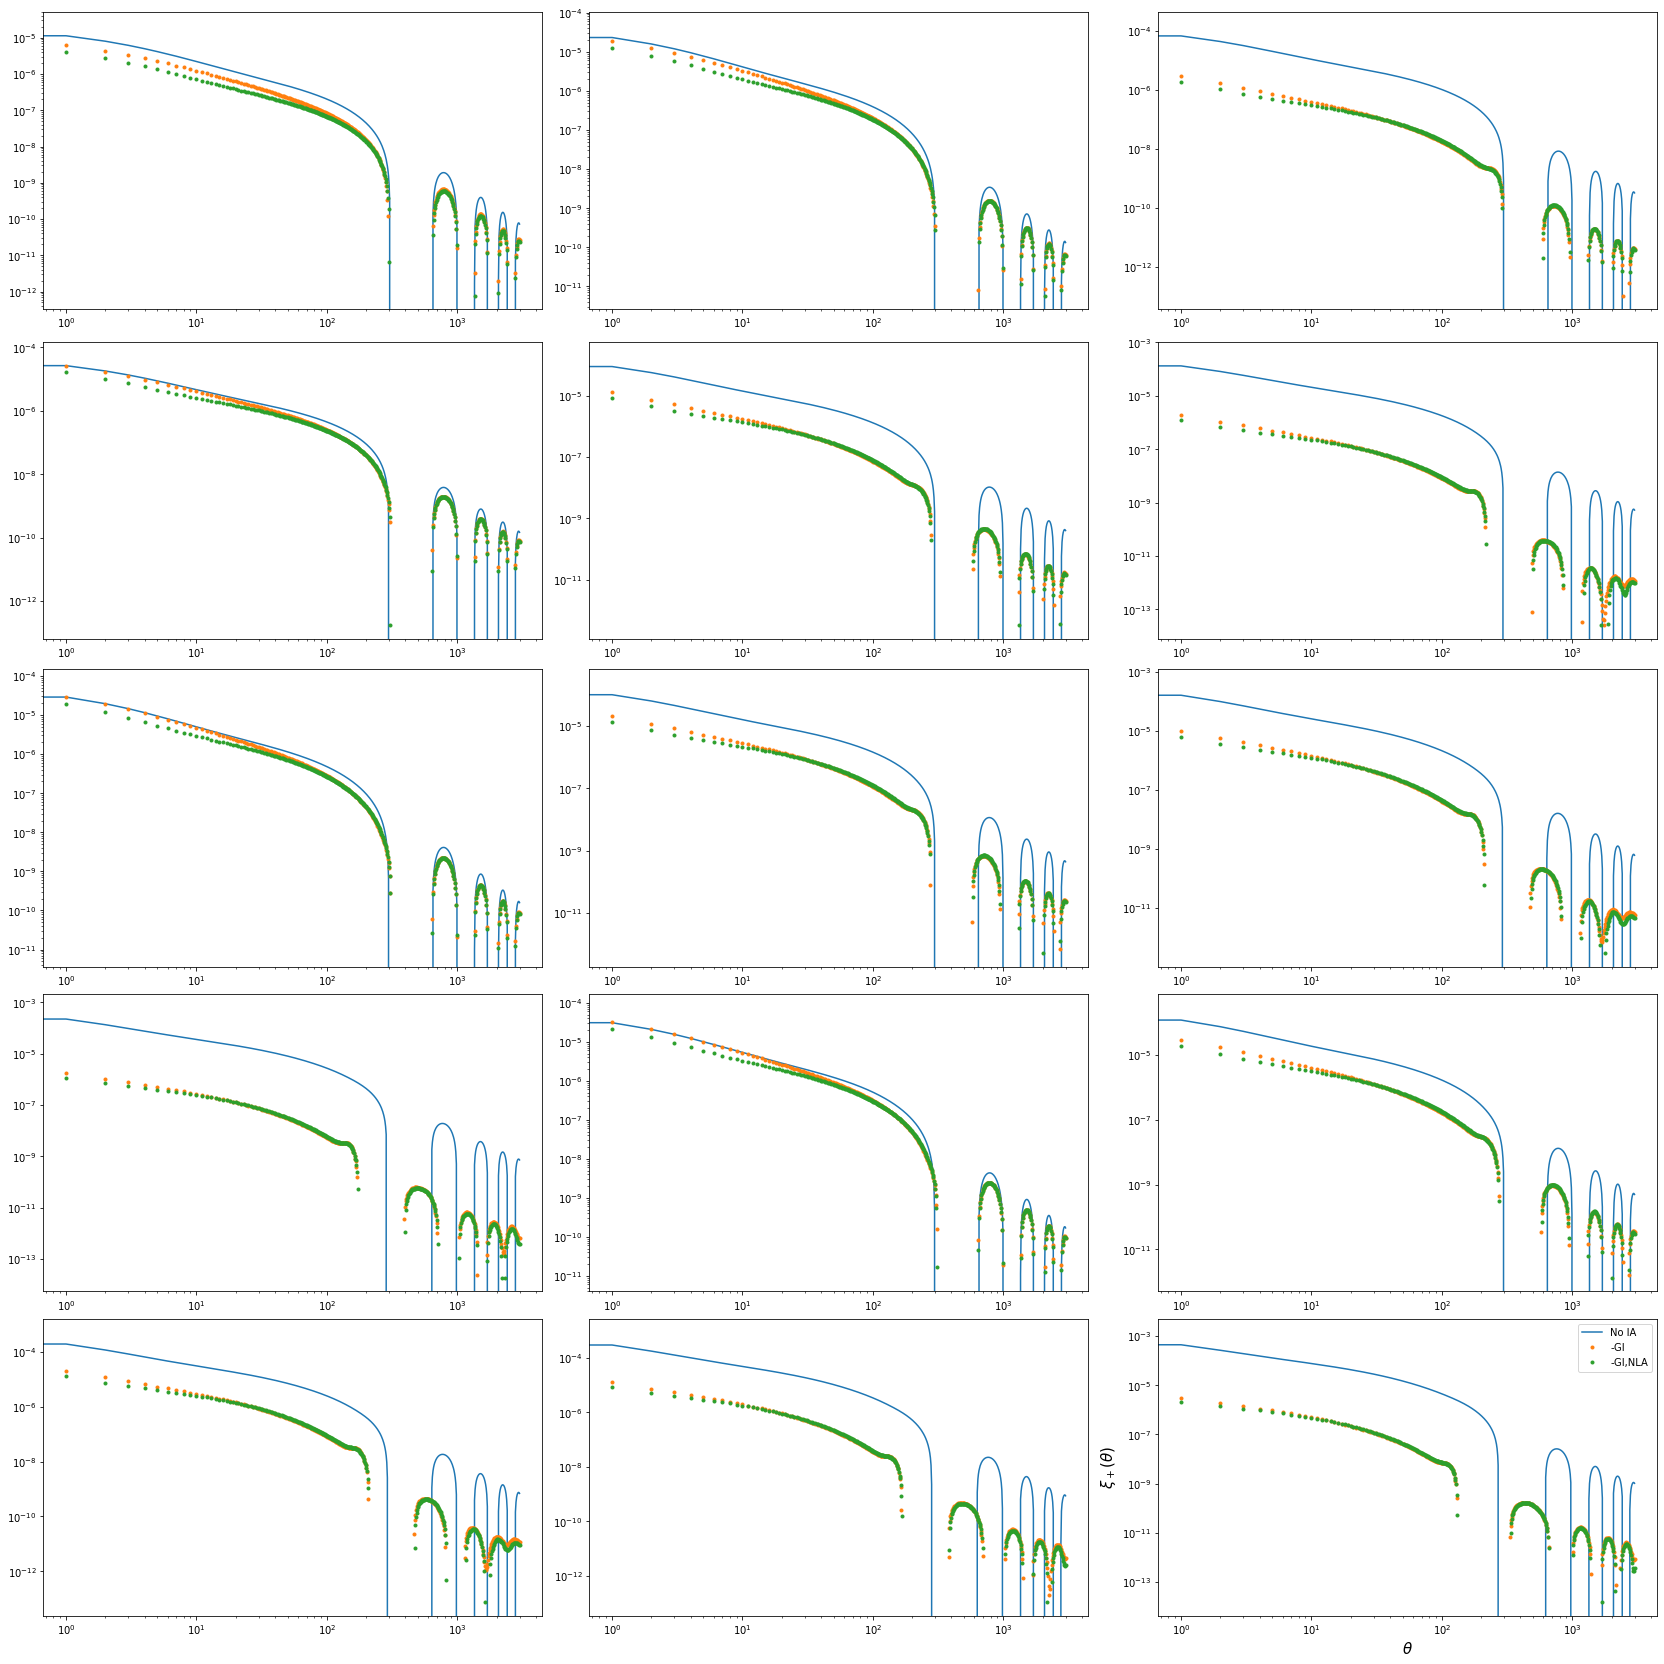

In [33]:
k=theta
figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 3
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(shear_GG_plus))
for ax, pi in zip(axs, shear_GG_plus):
    ax.loglog(theta, pi,label='No IA')
#for ax, px in zip(axs, shear_II_NLA_plus):
    #ax.loglog(theta, px,'--',label='II,NLA')
#for ax, pj in zip(axs, shear_II_plus):
    #ax.loglog(theta, pj,'.',label='II')
for ax, pjk in zip(axs, shear_GI_plus):
    ax.loglog(theta,-pjk,'.',label='-GI')
for ax, pjj in zip(axs, shear_GI_NLA_plus):
    ax.loglog(theta, -pjj,'.',label='-GI,NLA')
    plt.xlabel(r'$\theta$', fontsize=15)
    plt.ylabel(r'$\xi_+(\theta)$', fontsize=15)
legend(loc='upper right')
#fig.savefig("pos_cross.png",dpi=250)

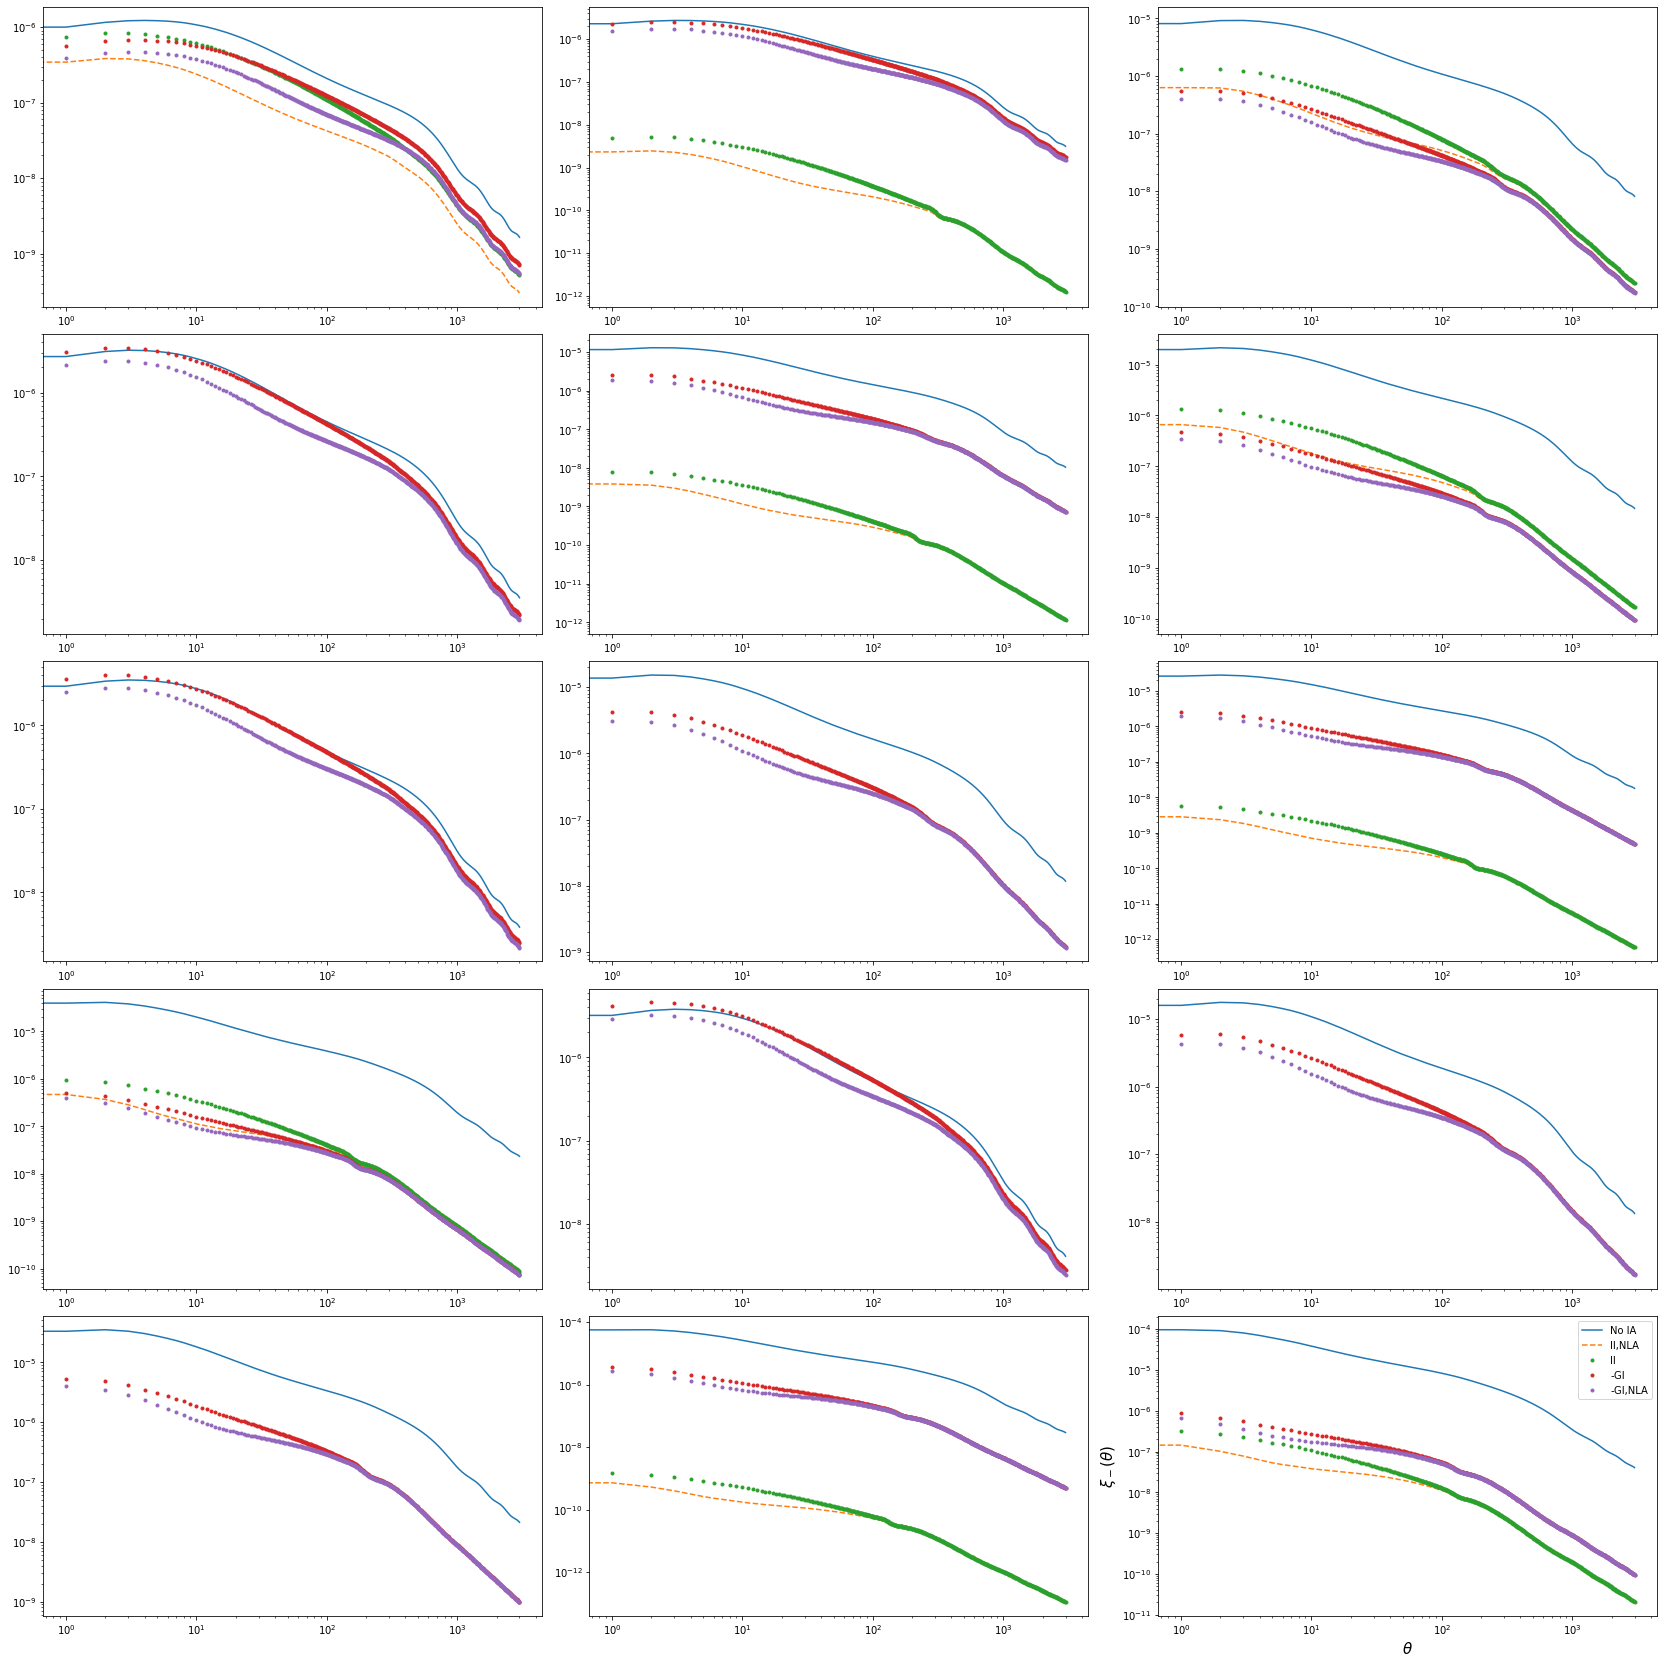

In [34]:
k=theta
figsize = (23, 23)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 3
rows =5
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(shear_GG_minus))

for ax, pi in zip(axs, shear_GG_minus):
    ax.loglog(theta, pi,label='No IA')
for ax, px in zip(axs, shear_II_NLA_minus):
    ax.loglog(theta, px,'--',label='II,NLA')
for ax, pj in zip(axs, shear_II_minus):
    ax.loglog(theta, pj,'.',label='II')
for ax, pjk in zip(axs, shear_GI_minus):
    ax.loglog(theta,-pjk,'.',label='-GI')
for ax, pjj in zip(axs, shear_GI_NLA_minus):
    ax.loglog(theta, -pjj,'.',label='-GI,NLA')
plt.xlabel(r'$\theta$', fontsize=15)
plt.ylabel(r'$\xi_-(\theta)$', fontsize=15)

legend(loc='upper right')
#fig.savefig("neg_cross.png",dpi=250)

In [35]:
names=('NO IA+','NO IA-','GI+','GI-','GI_NLA+','GI_NLA-','II+','II-','II_NLA+','II_NLA-','theta', 'bin_comb' )

In [36]:
index=[]
for i in range(5):
    for j in range(i+1):
        index.append([i+1,j+1])
index=np.stack(index)

In [37]:
thetax=[]
for i in range(len(shear_GG_plus)):
    thetax.append(theta)

In [38]:
theta=np.stack(thetax)

In [39]:

t = Table([shear_GG_plus,shear_GG_minus, shear_GI_plus,shear_GI_minus,shear_GI_NLA_plus,shear_GI_NLA_minus,shear_II_plus,shear_II_minus,shear_II_NLA_plus,shear_II_NLA_minus,theta,np.stack(index)], names=names)
#t.write('theo_prediction.fits', format='fits')

In [40]:
t

NO IA+ [430],NO IA- [430],GI+ [430],GI- [430],GI_NLA+ [430],GI_NLA- [430],II+ [430],II- [430],II_NLA+ [430],II_NLA- [430],theta [430],bin_comb [2]
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
2.193798981753861e-05 .. 7.267211065016163e-11,7.298738241990604e-07 .. 1.6515175438555404e-09,-1.2012644186693088e-05 .. -2.5740367737961834e-11,-3.1587757192342073e-07 .. -7.088511277394535e-10,-8.093313180675216e-06 .. -2.283433347963692e-11,-2.4000722071276787e-07 .. -5.417064956964531e-10,1.4155018256559944e-05 .. 1.8720996786632737e-11,2.3258926058410657e-07 .. 5.194570017564302e-10,6.1129680743861655e-06 .. 1.1563786583057221e-11,1.3449931959434098e-07 .. 3.0163138145779335e-10,0.0 .. 3000.0,1 .. 1
4.731904624136091e-05 .. 1.3248650550190163e-10,1.3929704205785715e-06 .. 3.1438269793091918e-09,-4.23726864378245e-05 .. -6.181031786214595e-11,-7.861016764949416e-07 .. -1.7561117002397601e-09,-2.855425948293328e-05 .. -5.839058346239637e-11,-6.634845668409028e-07 .. -1.4900976694811297e-09,8.210311875253633e-08 .. 3.6634761399905354e-14,5.769914372563135e-10 .. 1.2568319386945618e-12,3.552967652725007e-08 .. 3.3687029482802095e-14,5.297677629514417e-10 .. 1.1708449771768267e-12,0.0 .. 3000.0,2 .. 1
0.00015178904661615285 .. 3.189024984763705e-10,3.622200370559169e-06 .. 8.13729374968761e-09,-8.362663830283514e-06 .. -4.056756608252669e-12,-7.946471533901402e-08 .. -1.733510429888923e-10,-5.766684668651622e-06 .. -3.7892759395525185e-12,-7.728966674243472e-08 .. -1.6945181907792563e-10,2.043615409683144e-05 .. 6.171265872729028e-12,1.1581948434863999e-07 .. 2.490619320307111e-10,8.951343677381372e-06 .. 4.358261465373736e-12,1.0807805984693305e-07 .. 2.3561258020401277e-10,0.0 .. 3000.0,2 .. 2
5.507331266050985e-05 .. 1.473555787332044e-10,1.5791746295796395e-06 .. 3.560716174325635e-09,-5.7244817060644846e-05 .. -7.703858515685843e-11,-9.87985732185042e-07 .. -2.2045457040829925e-09,-3.861243716061806e-05 .. -7.338847861093517e-11,-8.510090985061458e-07 .. -1.908823834628039e-09,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 3000.0,3 .. 1
0.00020823543004595883 .. 3.973844117425378e-10,4.644268118167675e-06 .. 1.0415694684570867e-08,-3.802783612396551e-05 .. -1.552187905118511e-11,-3.3831324919629697e-07 .. -7.350554535632635e-10,-2.636276271083915e-05 .. -1.4249383294195008e-11,-3.298290194770434e-07 .. -7.203738777207286e-10,1.1723966204910925e-07 .. 2.2687385192393027e-14,5.522584249248225e-10 .. 1.1698808426838796e-12,5.1879007525320096e-08 .. 1.2795386412847975e-14,5.199902173557942e-10 .. 1.1207102583019582e-12,0.0 .. 3000.0,3 .. 2
0.00033614844018107815 .. 5.270169585453314e-10,6.640552241197446e-06 .. 1.4833686860595697e-08,-6.552945503541432e-06 .. -1.206765136318172e-12,-4.3825071056847164e-08 .. -9.351688172297648e-11,-4.649984253404843e-06 .. -9.461305016515388e-13,-4.306094469270488e-08 .. -9.247856914346064e-11,1.952105214174386e-05 .. 3.0667238360346668e-12,7.979813535506632e-08 .. 1.672433095484794e-10,8.714826589997431e-06 .. 1.4446686911291905e-12,7.526818842605772e-08 .. 1.6105308750562956e-10,0.0 .. 3000.0,3 .. 3
5.980487268464556e-05 .. 1.5876838269324086e-10,1.692791565939052e-06 .. 3.81741125467901e-09,-6.632004639134385e-05 .. -8.633127375688659e-11,-1.1111769956413057e-06 .. -2.47818328254638e-09,-4.4750103793378084e-05 .. -8.25275355358326e-11,-9.654356782442959e-07 .. -2.1643193966996313e-09,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 3000.0,4 .. 1
0.00024359057824161037 .. 4.4598901555318684e-10,5.278993703295607e-06 .. 1.1830261892887838e-08,-6.282743409328217e-05 .. -2.442397239683521e-11,-5.489245579341669e-07 .. -1.1913153913573016e-09,-4.361764594203339e-05 .. -2.2293998917725827e-11,-5.354917215535786e-07 .. -1.1683201270500156e-09,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 3000.0,4 .. 2
0.0004333151156362136 .. 6.138095579556082e-10,8.055231274640115e-06 .. 1.7956501634007367e-08,-3.5756368949568794e-05 .. -5.882535394978165e-12,-2.2